In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Reshape,Lambda,Convolution2D, MaxPooling2D, UpSampling2D, Flatten,Deconvolution2D
from keras.models import Model
from keras import backend as K
from keras import objectives
from keras.datasets import mnist

from sklearn.cross_validation import train_test_split


Using TensorFlow backend.
/home/kris/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [25]:
L=32
data=np.loadtxt("data/output_config.dat")
len_s=data.shape[0]
temperature=data[:,-1]
configurations=data[:,:-1].reshape((len_s,L,L,1))
configurations=(configurations+np.pi)/(2*np.pi)

In [26]:
img_rows,img_cols=L,L
intermediate_dim=248
latent_dim=2
batch_size=20
epsilon_std=1.0
nb_filters=16
input_img = Input(batch_shape=(batch_size,L,L,1))


def my_loss(x, x_decoded_mean):
    # NOTE: binary_crossentropy expects a batch_size by dim
    # for x and x_decoded_mean, so we MUST flatten these!
    xc = (1+K.cos(K.flatten(x*2*np.pi)))/2
    xc_decoded_mean =(1+K.cos(K.flatten(x_decoded_mean*2*np.pi)))/2
    xs = (1+K.sin(K.flatten(x*2*np.pi)))/2
    xs_decoded_mean =(1+K.sin(K.flatten(x_decoded_mean*2*np.pi)))/2
#    xent_loss =objectives.mean_squared_error(xc,xc_decoded_mean)+objectives.mean_squared_error(xs,xs_decoded_mean)
    xent_loss =objectives.binary_crossentropy(xc,xc_decoded_mean)+objectives.binary_crossentropy(xs,xs_decoded_mean)
#   xent_loss=img_rows * img_cols*xent_loss
    kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return xent_loss/2 + kl_loss

             
x = Convolution2D(nb_filters, 3, 3, activation='relu', border_mode='same',subsample=(2, 2))(input_img)
x = Convolution2D(nb_filters, 3, 3, activation='relu', border_mode='same',subsample=(1, 1))(x)
#x = Convolution2D(nb_filters, 3, 3, activation='relu', border_mode='same',subsample=(2, 2))(x)
##################
flat = Flatten()(x)

hidden = Dense(intermediate_dim, activation='relu')(flat)

z_mean = Dense(latent_dim)(hidden)
z_log_var = Dense(latent_dim)(hidden)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim),
                              mean=0., std=epsilon_std)
    return z_mean + K.exp(z_log_var) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
# so you could write `Lambda(sampling)([z_mean, z_log_var])`
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
#################

# we instantiate these layers separately so as to reuse them later
#x = Dense(intermediate_dim, activation='relu')(z)
x = Dense(nb_filters * 16 * 16, activation='relu')(z)
x=Reshape(target_shape=(16,16,nb_filters))(x)
#x = Deconvolution2D(nb_filters, 2, 2,output_shape=(batch_size,8,8,nb_filters), activation='relu', border_mode='valid',subsample=(2, 2))(x)
x = Deconvolution2D(nb_filters, 2, 2,output_shape=(batch_size,32,32,nb_filters), activation='relu', border_mode='valid',subsample=(2, 2))(x)
x = Convolution2D(nb_filters, 2, 2,activation='relu', border_mode='same',subsample=(1, 1))(x)
decoded = Convolution2D(1, 2, 2, activation='sigmoid', border_mode='same',subsample=(1, 1))(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='rmsprop', loss=my_loss)
autoencoder.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_4 (InputLayer)             (20, 32, 32, 1)       0                                            
____________________________________________________________________________________________________
convolution2d_13 (Convolution2D) (20, 16, 16, 16)      160         input_4[0][0]                    
____________________________________________________________________________________________________
convolution2d_14 (Convolution2D) (20, 16, 16, 16)      2320        convolution2d_13[0][0]           
____________________________________________________________________________________________________
flatten_4 (Flatten)              (20, 4096)            0           convolution2d_14[0][0]           
___________________________________________________________________________________________

In [17]:
x_train, x_test = train_test_split(configurations, train_size = 0.9)
#x_train1=config_expand

autoencoder.fit(x_train, x_train,
                nb_epoch=50,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(x_test, x_test)
              )

Train on 1800 samples, validate on 200 samples
Epoch 1/50
1800/1800 [==============================] - 6s - loss: 250.9934 - val_loss: 236.4760
Epoch 2/50
1800/1800 [==============================] - 6s - loss: 222.6243 - val_loss: 224.3511
Epoch 3/50
1800/1800 [==============================] - 5s - loss: 215.5487 - val_loss: 218.8646
Epoch 4/50
1800/1800 [==============================] - 6s - loss: 212.0925 - val_loss: 214.9415
Epoch 5/50
1800/1800 [==============================] - 5s - loss: 209.8326 - val_loss: 216.5924
Epoch 6/50
1800/1800 [==============================] - 5s - loss: 206.1461 - val_loss: 212.8567
Epoch 7/50
1800/1800 [==============================] - 5s - loss: 204.9861 - val_loss: 209.9002
Epoch 8/50
1800/1800 [==============================] - 6s - loss: 203.7446 - val_loss: 211.4922
Epoch 9/50
1800/1800 [==============================] - 6s - loss: 203.4347 - val_loss: 206.1168
Epoch 10/50
1800/1800 [==============================] - 6s - loss: 201.1549 - v

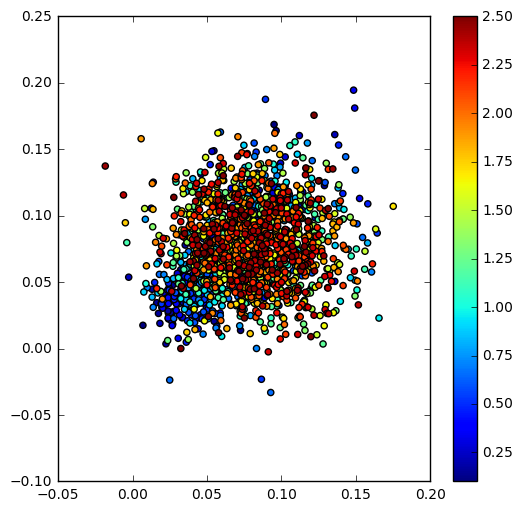

In [27]:
encoder = Model(input_img, z_mean)

# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(configurations, batch_size=batch_size)
x_test_encoded.shape
show_n=2000
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:show_n, 0], x_test_encoded[:show_n, 1],c=temperature[:show_n])
plt.colorbar()
plt.show()

In [28]:
decoded_imgs = autoencoder.predict(configurations,batch_size=batch_size)

L=32
X, Y = np.mgrid[0:L, 0:L]
    
def vortex_plot_compare(tn):
    plt.figure(figsize=(14, 7))
    x_test=configurations
    x_new,y_new,xy=np.cos(2*np.pi*x_test[tn,:,:,0]),np.sin(2*np.pi*x_test[tn,:,:,0]),2*np.pi*x_test[tn,:,:,0]
    theta=2*np.pi*decoded_imgs[tn,:,:,0]
    x_new1,y_new1,xy1=np.cos(theta),np.sin(theta),theta
    p1=plt.subplot(121)
    p1.quiver(X,Y,x_new,y_new,clim=[-3.15,3.15])
    plt.axis('equal')
    plt.axis('off')
    p2=plt.subplot(122)
    p2.quiver(X,Y,x_new1,y_new1,clim=[-3.15,3.15])
#    plt.axis('equal')
#    plt.axis('off')
#    plt.title('='.join(('T',str(round(temperature[tn],2)))))
#    cbar = plt.colorbar(ticks=[-3.14, 0, 3.14])
    #    cbar.ax.set_yticklabels([r"\pi", r"0", r"-\pi"])
    plt.axis('equal')
    plt.axis('off')
    plt.show()

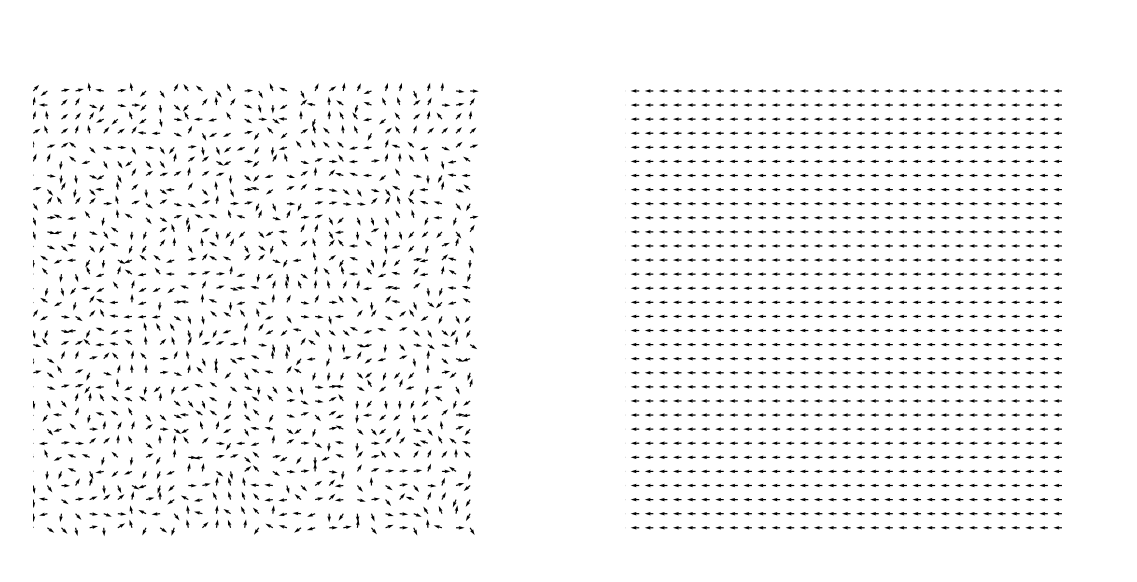

In [29]:
vortex_plot_compare(np.random.randint(2000))